In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib as mpl

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split


In [2]:
path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [4]:
# Veri Yükleme ve Ön İşleme
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
full_dataset = torchvision.datasets.ImageFolder(root=path, transform=transform_train)


train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])


train_size = int(0.8 * len(train_val_dataset))  # 80% for training
validation_size = len(train_val_dataset) - train_size  # 20% for validation
train_dataset, validation_dataset = random_split(train_val_dataset, [train_size, validation_size])


# DataLoader'ların oluşturulması
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [6]:
!pip install facenet-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:0000:0100:01


In [7]:
from facenet_pytorch import InceptionResnetV1


In [8]:
inception = InceptionResnetV1(pretrained='vggface2').eval()


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [9]:
# Özelleştirilmiş model sınıfınız
class CustomInception(nn.Module):
    def __init__(self, num_classes=105):
        super(CustomInception, self).__init__()
        # Inception modelinin evrişimsel katmanlarını al
        self.inception = nn.Sequential(*list(inception.children())[:-6])
        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv1 = nn.Conv2d(1792, 1024, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm2d(1792)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.40)
        self.fc2 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        #self.fc3 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.45)
        self.dropout3 = nn.Dropout(0.55)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.out = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.inception(x)
        x = self.bn4(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        #x = self.global_avg_pool(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.out(x)
        return x


In [10]:
model = CustomInception(num_classes=105)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


CustomInception(
  (inception): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [12]:
!pip install torchsummary

In [13]:
from torchsummary import summary

In [14]:
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73]               0
           Conv2d-14           [-1, 80,

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=0.001)

In [16]:
from tqdm.notebook import tqdm


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
def calculate_metrics(preds, labels):
    """
    preds: Modelin tahminleri, genellikle en yüksek olasılığa sahip sınıfın indeksleri.
    labels: Gerçek etiketler.
    Bu fonksiyon, verilen tahminler ve etiketler için precision, recall ve f1 score değerlerini döndürür.
    """
    # PyTorch Tensor'larından NumPy dizilerine dönüştür
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # Precision, recall ve f1 score'u hesapla
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    
    return precision, recall, f1

In [18]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_preds = []
    total_labels = []

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        #_, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
        total_preds.extend(preds.view(-1).tolist())
        total_labels.extend(labels.data.view(-1).tolist())

    precision, recall, f1 = calculate_metrics(torch.tensor(total_preds), torch.tensor(total_labels))
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    
    return epoch_loss, epoch_acc, precision, recall, f1

def validate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    total_preds = []
    total_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            #_, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            total_preds.extend(preds.view(-1).tolist())
            total_labels.extend(labels.data.view(-1).tolist())

    precision, recall, f1 = calculate_metrics(torch.tensor(total_preds), torch.tensor(total_labels))
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc, precision, recall, f1


In [19]:
train_acc_history = []
val_acc_history = []

train_loss_history = []
val_loss_history = []
for epoch in tqdm(range(20), desc="Epochs", leave=True):
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_model(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate_model(model, validation_loader, criterion)


    print(f'Epoch {epoch+1}/{20}')
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} F1: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}')

    
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    scheduler.step(val_loss)



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/20
Train Loss: 3.1119 Acc: 0.2931 Precision: 0.2824 Recall: 0.2768 F1: 0.2670
Validation Loss: 3.5310 Acc: 0.4765 Precision: 0.6489 Recall: 0.4606 F1: 0.4540


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/20
Train Loss: 1.1845 Acc: 0.7520 Precision: 0.7555 Recall: 0.7375 F1: 0.7399
Validation Loss: 3.2774 Acc: 0.5225 Precision: 0.7408 Recall: 0.5201 F1: 0.5298


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/20
Train Loss: 0.5413 Acc: 0.8934 Precision: 0.8944 Recall: 0.8897 F1: 0.8915
Validation Loss: 3.0363 Acc: 0.5563 Precision: 0.8327 Recall: 0.5613 F1: 0.5738


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/20
Train Loss: 0.2404 Acc: 0.9571 Precision: 0.9574 Recall: 0.9563 F1: 0.9567
Validation Loss: 2.7659 Acc: 0.6707 Precision: 0.8577 Recall: 0.6689 F1: 0.6878


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/20
Train Loss: 0.1203 Acc: 0.9838 Precision: 0.9839 Recall: 0.9834 F1: 0.9836
Validation Loss: 2.5666 Acc: 0.7388 Precision: 0.8465 Recall: 0.7369 F1: 0.7292


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6/20
Train Loss: 0.0518 Acc: 0.9950 Precision: 0.9951 Recall: 0.9950 F1: 0.9950
Validation Loss: 2.3676 Acc: 0.8378 Precision: 0.8905 Recall: 0.8395 F1: 0.8400


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7/20
Train Loss: 0.0187 Acc: 0.9993 Precision: 0.9993 Recall: 0.9992 F1: 0.9992
Validation Loss: 2.2307 Acc: 0.8906 Precision: 0.9120 Recall: 0.8914 F1: 0.8878


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8/20
Train Loss: 0.0103 Acc: 0.9999 Precision: 0.9999 Recall: 0.9999 F1: 0.9999
Validation Loss: 2.1671 Acc: 0.8828 Precision: 0.9069 Recall: 0.8847 F1: 0.8793


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9/20
Train Loss: 0.0062 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 2.1174 Acc: 0.9045 Precision: 0.9231 Recall: 0.9070 F1: 0.9031


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10/20
Train Loss: 0.0050 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 2.0702 Acc: 0.9084 Precision: 0.9237 Recall: 0.9092 F1: 0.9057


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11/20
Train Loss: 0.0037 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 2.0058 Acc: 0.9195 Precision: 0.9283 Recall: 0.9178 F1: 0.9150


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12/20
Train Loss: 0.0035 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 2.0439 Acc: 0.9059 Precision: 0.9200 Recall: 0.9080 F1: 0.9026


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13/20
Train Loss: 0.0028 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.9988 Acc: 0.9127 Precision: 0.9259 Recall: 0.9138 F1: 0.9097


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14/20
Train Loss: 0.0024 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.9885 Acc: 0.9198 Precision: 0.9285 Recall: 0.9209 F1: 0.9161


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15/20
Train Loss: 0.0020 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.9072 Acc: 0.9269 Precision: 0.9336 Recall: 0.9267 F1: 0.9227


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16/20
Train Loss: 0.0021 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.8825 Acc: 0.9262 Precision: 0.9344 Recall: 0.9266 F1: 0.9236


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17/20
Train Loss: 0.0017 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.8598 Acc: 0.9262 Precision: 0.9343 Recall: 0.9263 F1: 0.9231


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18/20
Train Loss: 0.0020 Acc: 0.9999 Precision: 0.9999 Recall: 0.9999 F1: 0.9999
Validation Loss: 1.8371 Acc: 0.9291 Precision: 0.9372 Recall: 0.9316 F1: 0.9281


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19/20
Train Loss: 0.0015 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.8194 Acc: 0.9294 Precision: 0.9408 Recall: 0.9312 F1: 0.9295


Training:   0%|          | 0/88 [00:00<?, ?it/s]

Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20/20
Train Loss: 0.0013 Acc: 1.0000 Precision: 1.0000 Recall: 1.0000 F1: 1.0000
Validation Loss: 1.7705 Acc: 0.9355 Precision: 0.9431 Recall: 0.9369 F1: 0.9344


In [26]:
def test_model(model, test_loader, criterion):
    model.eval()  # Modeli değerlendirme/inference moduna alır
    running_loss = 0.0
    running_corrects = 0

    total_preds = []
    total_labels = []

    with torch.no_grad():  # Gradyan hesaplamalarını devre dışı bırakır
        for inputs, labels in tqdm(test_loader, desc="Testing", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            total_preds.extend(preds.view(-1).tolist())
            total_labels.extend(labels.data.view(-1).tolist())

    precision, recall, f1 = calculate_metrics(torch.tensor(total_preds), torch.tensor(total_labels))
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')

# Test model
test_model(model, test_loader, criterion)

Testing:   0%|          | 0/28 [00:00<?, ?it/s]

Test Loss: 1.7767 Acc: 0.9467 Precision: 0.9521 Recall: 0.9473 F1: 0.9463


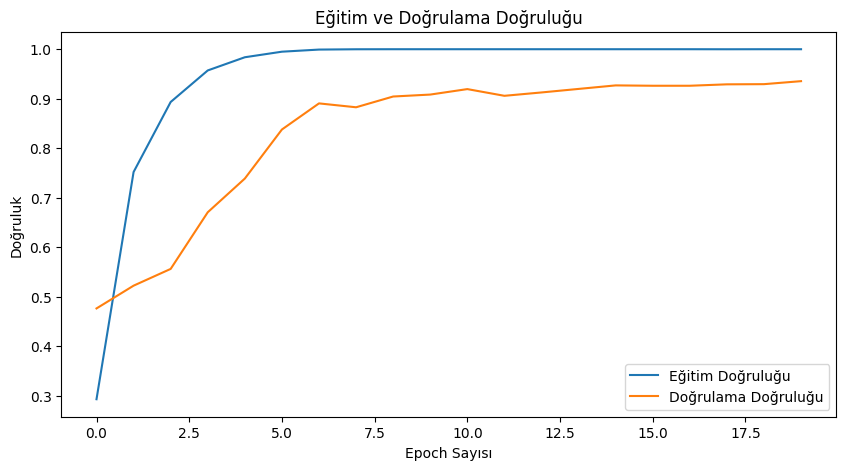

In [27]:
train_acc_history = [x.cpu().numpy() if torch.is_tensor(x) else x for x in train_acc_history]
val_acc_history = [x.cpu().numpy() if torch.is_tensor(x) else x for x in val_acc_history]

# Şimdi matplotlib ile çizim yapabilirsiniz
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Eğitim Doğruluğu')
plt.plot(val_acc_history, label='Doğrulama Doğruluğu')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

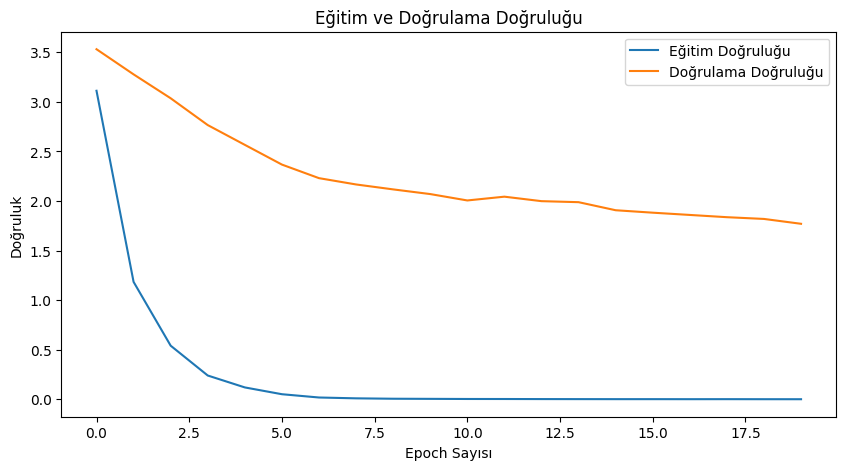

In [28]:
train_loss_history = [x.cpu().numpy() if torch.is_tensor(x) else x for x in train_loss_history]
val_loss_history = [x.cpu().numpy() if torch.is_tensor(x) else x for x in val_loss_history]

# Şimdi matplotlib ile çizim yapabilirsiniz
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Eğitim Doğruluğu')
plt.plot(val_loss_history, label='Doğrulama Doğruluğu')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.show()

In [29]:
# Modeli kaydet
torch.save(model.state_dict(), 'weights_inception.pth')


In [30]:
# Modeli yükle
model_loaded = CustomInception(num_classes=105)  # Model örneği
model_loaded.load_state_dict(torch.load('weights_inception.pth'))
model_loaded = model_loaded.to(device)  # Modeli doğru cihaza taşıyın
model_loaded.eval()  # Değerlendirme moduna geçiş

CustomInception(
  (inception): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [ ]:
from torchvision import transforms
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Görüntüyü yükle ve işle
image_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Dwayne Johnson/Dwayne Johnson132_1583.jpg'  # Test görüntüsünün yolu
image = Image.open(image_path).convert('RGB')

# Görüntüyü modelin beklediği formata dönüştür
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception modeli için uygun boyut
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet için ortalama ve std
])

image_tensor = transform(image).unsqueeze(0)  # Batch boyutunu ekleyin
image_tensor = image_tensor.to(device)  # Görüntüyü doğru cihaza taşıyın

# Modelle tahmin yap
with torch.no_grad():
    outputs = model_loaded(image_tensor)
    _, preds = torch.max(outputs, 1)

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Tahmin edilen sınıf numarasını al
predicted_class_num = preds.item()

# Tahmin edilen sınıf numarasını sınıf adına çevir
predicted_class_name = idx_to_class[predicted_class_num]

plt.imshow(image)
plt.axis('off')  # Eksenleri kapat

# Tahmin edilen etiketi resmin üzerine yaz
# (10, 25) başlangıç konumunu belirtir. Bu değerleri ayarlayarak metnin pozisyonunu değiştirebilirsiniz.
plt.text(10, 25, predicted_class_name, color='white', fontsize=12, 
         bbox=dict(facecolor='red', alpha=0.5))

# Görseli göster
plt.show()